# Goodreads Reviews Dataset Exploration

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
goodreads_df = pd.read_csv('goodreads-reviews-full-dataset.csv')

In [5]:
goodreads_df.head()

,review score,review text
0,4,Suzanne Collins has balls ovaries of steel to ...
1,5,Dystopian Perfection.\n\nIn a post-apocalyptic...
2,4,Latest is up - a serious take on writing Young...
3,5,I was forced into watching Mockingjay: Part II...
4,5,"My ""Epic Book Recipe"" Checklist for The Hunger..."


In [6]:
goodreads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11683 entries, 0 to 11682
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review score  11683 non-null  int64 
 1   review text   11683 non-null  object
dtypes: int64(1), object(1)
memory usage: 182.7+ KB


In [7]:
goodreads_df.describe()

,review score
count,11683.000000
mean,3.985021
std,1.267385
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [8]:
goodreads_df.shape

(11683, 2)

In [10]:
goodreads_df.isnull().sum()

review score    0
review text     0
dtype: int64

In [11]:
goodreads_df['review score'].value_counts()

5    5565
4    3127
3    1224
1     982
2     785
Name: review score, dtype: int64

In [16]:
goodreads_df.dtypes

review score     int64
review text     object
dtype: object

## Getting review word count

### Using a sample dataframe to test

In [12]:
sample_df = goodreads_df.sample(50)
sample_df.head()

,review score,review text
6659,4,"The Silmarillion, J.R.R. Tolkien\n\nThe Silmar..."
8537,5,"Who said Stephen King only wrote horror? ""Diff..."
6114,5,This is one of my favorite books of all time!!...
9888,4,Much more readable and fun then I imagined!\n“...
585,3,"Randomness GALORE...! ...& yet, ISN'T THAT the..."


In [17]:
sample_df['review_word_count'] = sample_df['review text'].str.split().apply(len)

In [18]:
sample_df.head()

,review score,review text,review_word_count
6659,4,"The Silmarillion, J.R.R. Tolkien\n\nThe Silmar...",719
8537,5,"Who said Stephen King only wrote horror? ""Diff...",747
6114,5,This is one of my favorite books of all time!!...,352
9888,4,Much more readable and fun then I imagined!\n“...,324
585,3,"Randomness GALORE...! ...& yet, ISN'T THAT the...",136


<AxesSubplot:>

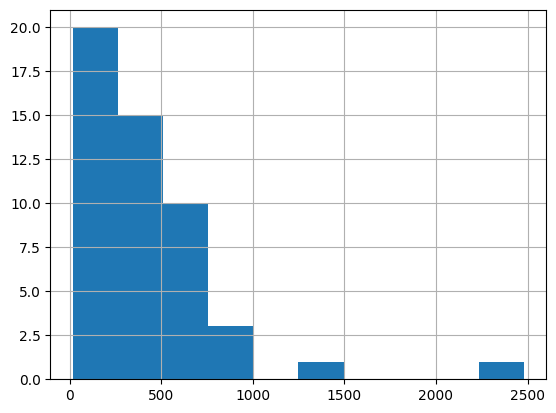

In [20]:
sample_df['review_word_count'].hist()

### Now doing the same on the full df

In [21]:
goodreads_df['review_word_count'] = goodreads_df['review text'].str.split().apply(len)

<AxesSubplot:>

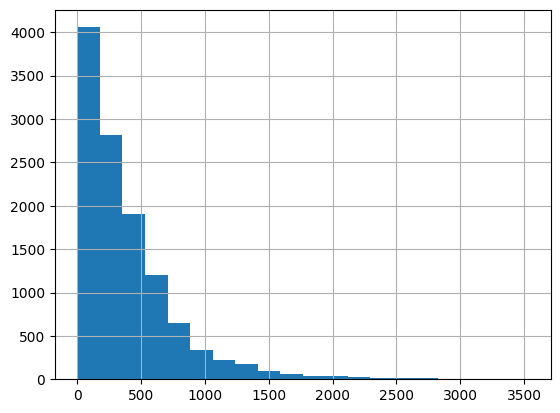

In [23]:
goodreads_df['review_word_count'].hist(bins=20)

In [24]:
goodreads_df.describe()

,review score,review_word_count
count,11683.000000,11683.000000
mean,3.985021,389.486005
std,1.267385,399.870747
min,1.000000,0.000000
25%,3.000000,114.000000
50%,4.000000,283.000000
75%,5.000000,528.000000
max,5.000000,3534.000000


This shows that there are some outliers in terms of review size, but the majority of reviews are under 500 words. Therefore, will be trimming the review length to around 500 words and padding up to there as a starting point, and potentially trimming it further if it would speed up the process. I think I will keep the last 500 word of longer reviews, as they are more likely to be representative of the associated review score from the conclusion.

In [26]:
goodreads_df[goodreads_df['review_word_count'] == float(0)].count()

review score         1
review text          1
review_word_count    1
dtype: int64

# Model training

### Imports

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

2023-07-19 15:09:36.415118: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Testing text preprocessing on sample df

### Making the reviews into text sequences

In [28]:
X = sample_df['review text']
y = sample_df['review score']

In [ ]:
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=0.20, random_state=1)

In [34]:
X.head()

6659    The Silmarillion, J.R.R. Tolkien\n\nThe Silmar...
8537    Who said Stephen King only wrote horror? "Diff...
6114    This is one of my favorite books of all time!!...
9888    Much more readable and fun then I imagined!\n“...
585     Randomness GALORE...! ...& yet, ISN'T THAT the...
Name: review text, dtype: object

In [33]:
X_sequences = [text_to_word_sequence(_) for _ in X]

In [35]:
X_sequences[0]

['the',
 'silmarillion',
 'j',
 'r',
 'r',
 'tolkien',
 'the',
 'silmarillion',
 'is',
 'a',
 'collection',
 'of',
 'mythopoeic',
 'works',
 'by',
 'english',
 'writer',
 'j',
 'r',
 'r',
 'tolkien',
 'edited',
 'and',
 'published',
 'posthumously',
 'by',
 'his',
 'son',
 'christopher',
 'tolkien',
 'in',
 '1977',
 'with',
 'assistance',
 'from',
 'guy',
 'gavriel',
 'kay',
 'the',
 'silmarillion',
 'along',
 'with',
 'j',
 'r',
 'r',
 "tolkien's",
 'other',
 'works',
 'forms',
 'an',
 'extensive',
 'though',
 'incomplete',
 'narrative',
 'that',
 'describes',
 'the',
 'universe',
 'of',
 'eä',
 'in',
 'which',
 'are',
 'found',
 'the',
 'lands',
 'of',
 'valinor',
 'beleriand',
 'númenor',
 'and',
 'middle',
 'earth',
 'within',
 'which',
 'the',
 'hobbit',
 'and',
 'the',
 'lord',
 'of',
 'the',
 'rings',
 'take',
 'place',
 'this',
 'book',
 'is',
 'the',
 'first',
 'and',
 'last',
 'book',
 'of',
 'tolkien',
 'the',
 'story',
 'of',
 'the',
 'first',
 'period',
 'from',
 'the',
 '

### Removing Non-English characters from list

In [54]:
import unicodedata
 
def is_english(word):
    for character in word:
        if character.isalpha() and unicodedata.name(character).startswith(('LATIN', 'COMMON')):
            continue
        else:
            return False
    return True
 
def remove_non_english_words(word_sequences):
    filtered_sequences = []
    for word_sequence in word_sequences:
        filtered = filter(is_english, word_sequence)  
        filtered_sequences.append([s for s in filtered])
#         english_str = ''.join(filtered)
#         output.append(english_str)
    return filtered_sequences

In [48]:
filtered = filter(is_english, X_sequences[0])

In [49]:
filtered_review = [s for s in filtered]    

In [50]:
filtered_review

['the',
 'silmarillion',
 'j',
 'r',
 'r',
 'tolkien',
 'the',
 'silmarillion',
 'is',
 'a',
 'collection',
 'of',
 'mythopoeic',
 'works',
 'by',
 'english',
 'writer',
 'j',
 'r',
 'r',
 'tolkien',
 'edited',
 'and',
 'published',
 'posthumously',
 'by',
 'his',
 'son',
 'christopher',
 'tolkien',
 'in',
 'with',
 'assistance',
 'from',
 'guy',
 'gavriel',
 'kay',
 'the',
 'silmarillion',
 'along',
 'with',
 'j',
 'r',
 'r',
 'other',
 'works',
 'forms',
 'an',
 'extensive',
 'though',
 'incomplete',
 'narrative',
 'that',
 'describes',
 'the',
 'universe',
 'of',
 'eä',
 'in',
 'which',
 'are',
 'found',
 'the',
 'lands',
 'of',
 'valinor',
 'beleriand',
 'númenor',
 'and',
 'middle',
 'earth',
 'within',
 'which',
 'the',
 'hobbit',
 'and',
 'the',
 'lord',
 'of',
 'the',
 'rings',
 'take',
 'place',
 'this',
 'book',
 'is',
 'the',
 'first',
 'and',
 'last',
 'book',
 'of',
 'tolkien',
 'the',
 'story',
 'of',
 'the',
 'first',
 'period',
 'from',
 'the',
 'imaginary',
 'world',
 

In [53]:
print(len(X_sequences[0]), len(filtered_review), sep='\n')

742
148


In [74]:
X_sequences_filtered = remove_non_english_words(X_sequences)

In [56]:
len(X_sequences_filtered[0])

148

In [61]:
X_sequences_filtered[0]

['the',
 'silmarillion',
 'j',
 'r',
 'r',
 'tolkien',
 'the',
 'silmarillion',
 'is',
 'a',
 'collection',
 'of',
 'mythopoeic',
 'works',
 'by',
 'english',
 'writer',
 'j',
 'r',
 'r',
 'tolkien',
 'edited',
 'and',
 'published',
 'posthumously',
 'by',
 'his',
 'son',
 'christopher',
 'tolkien',
 'in',
 'with',
 'assistance',
 'from',
 'guy',
 'gavriel',
 'kay',
 'the',
 'silmarillion',
 'along',
 'with',
 'j',
 'r',
 'r',
 'other',
 'works',
 'forms',
 'an',
 'extensive',
 'though',
 'incomplete',
 'narrative',
 'that',
 'describes',
 'the',
 'universe',
 'of',
 'eä',
 'in',
 'which',
 'are',
 'found',
 'the',
 'lands',
 'of',
 'valinor',
 'beleriand',
 'númenor',
 'and',
 'middle',
 'earth',
 'within',
 'which',
 'the',
 'hobbit',
 'and',
 'the',
 'lord',
 'of',
 'the',
 'rings',
 'take',
 'place',
 'this',
 'book',
 'is',
 'the',
 'first',
 'and',
 'last',
 'book',
 'of',
 'tolkien',
 'the',
 'story',
 'of',
 'the',
 'first',
 'period',
 'from',
 'the',
 'imaginary',
 'world',
 

In [59]:
len(X_sequences_filtered)

50

In [63]:
words_removed = 0
total_words = 0

for review, filtered_review in zip(X_sequences, X_sequences_filtered):
#     print(f"length of original review is {len(review)}.")
#     print(f"length of filtered review is {len(filtered_review)}.")
    
    words_removed += (len(review) - len(filtered_review))
    total_words += len(review)
print(f"The total words before filtering was {total_words}.")
print(f"The total words after filtering was {total_words-words_removed}.")
print(f"The total words removed by filtering was {words_removed}.")
print(f"The proportion of words removed by filtering was {round((words_removed/total_words)*100, 4)}.")

The total words before filtering was 21590.
The total words after filtering was 19336.
The total words removed by filtering was 2254.
The proportion of words removed by filtering was 10.44.


In [77]:
for filtered_review in X_sequences_filtered:
    print(len(filtered_review))

148
733
339
321
134
440
84
320
757
127
238
597
1326
368
17
306
106
552
184
367
257
236
523
31
75
135
969
101
84
695
189
489
96
124
341
390
103
598
25
252
902
118
621
2436
237
598
365
195
342
345


In [88]:
type(X_sequences_filtered[0][0])

str

In [92]:
def rejoin_reviews(filtered_sequences):
    review_texts = []
    for review_sequence in filtered_sequences:
        review_texts.append(" ".join(review_sequence))
    return review_texts

In [93]:
X_texts = rejoin_reviews(X_sequences_filtered)

In [94]:
X_texts[0]

'the silmarillion j r r tolkien the silmarillion is a collection of mythopoeic works by english writer j r r tolkien edited and published posthumously by his son christopher tolkien in with assistance from guy gavriel kay the silmarillion along with j r r other works forms an extensive though incomplete narrative that describes the universe of eä in which are found the lands of valinor beleriand númenor and middle earth within which the hobbit and the lord of the rings take place this book is the first and last book of tolkien the story of the first period from the imaginary world of tolkien the old drama in which the characters of lord of the rings can also find their roots other well known names of lord of the rings such as elrond and galadriel are also heroes of part of a short story in this book'

### Tokenizing and padding the filtered word sequences

In [95]:
num_words=10000
tokenizer = Tokenizer(num_words=num_words)

In [96]:
tokenizer.fit_on_texts(X_texts)

In [98]:
X_token = tokenizer.texts_to_sequences(X_texts)

In [100]:
X_pad = pad_sequences(X_token, dtype='float32', padding='pre', maxlen=400, truncating='pre')

In [101]:
X_pad[0]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

We have now got a functional preprocessing pipeline to make tensors ready for training the model. 